# Pricing European options
- 주어진 주식의 위험 확률 q 확인

In [4]:
import math

# 변수 초기화
r = 0.05  # 무위험 이자율 (annual risk-free rate)
T = 2     # 옵션의 만기 시간 (2년)
t = T / 2 # 한 단계당 시간 간격 (1년)
u = 1.2   # 주가 상승 비율 (20% 상승)
d = 0.8   # 주가 하락 비율 (20% 하락)

# 위험 중립 확률 계산
# q는 이항 모델에서 상승 상태로 갈 확률
q = (math.exp(r * t) - d) / (u - d)  # (무위험 성장 계수 - 하락 비율) / (상승 비율 - 하락 비율)

# 출력 확인 (필요 시 추가)
print(q)  # 위험 중립 확률 값 출력

0.6281777409400603


In [5]:
import math

# 변수 초기화
r = 0.05  # 무위험 이자율 (annual risk-free rate)
T = 2     # 만기 시간 (2년)
t = T / 2 # 한 단계당 시간 간격 (1년)
u = 1.2   # 주가 상승 비율
d = 0.8   # 주가 하락 비율

# 위험 중립 확률 계산
q = (math.exp(r * t) - d) / (u - d)
one_minus_q = 1 - q  # 하락 상태로 갈 확률

# 단말 노드에서의 풋 옵션 가치 (결과 이익)
p_uu = 0  # 주가가 두 번 상승한 경우
p_ud = 4  # 한 번 상승하고 한 번 하락한 경우
p_dd = 20 # 주가가 두 번 하락한 경우

# 중간 노드에서의 풋 옵션 가치
p_u = math.exp(-r * t) * (q * p_uu + one_minus_q * p_ud)  # 중간 노드에서 위쪽 분기의 가치
p_d = math.exp(-r * t) * (q * p_ud + one_minus_q * p_dd)  # 중간 노드에서 아래쪽 분기의 가치

# 초기 노드에서의 풋 옵션 현재 가치
p_0 = math.exp(-r * t) * (q * p_u + one_minus_q * p_d)

# 결과 출력
print(f"위험 중립 확률 q: {q:.5f}")
print(f"중간 노드에서의 옵션 가치 (p_u): ${p_u:.2f}, (p_d): ${p_d:.2f}")
print(f"풋 옵션의 현재 가치 (p_0): ${p_0:.2f}")

위험 중립 확률 q: 0.62818
중간 노드에서의 옵션 가치 (p_u): $1.41, (p_d): $9.46
풋 옵션의 현재 가치 (p_0): $4.19


# StockOption 기본 클래스 작성

In [1]:
import math

""" 
기본적인 주식 옵션 속성을 저장하는 클래스
"""
class StockOption(object):
    def __init__(
        self, S0, K, r=0.05, T=1, N=2, pu=0, pd=0, 
        div=0, sigma=0, is_put=False, is_am=False):
        """
        주식 옵션 기본 클래스를 초기화합니다.
        별도로 지정하지 않으면 유럽식 콜 옵션이 기본값입니다.

        :param S0: 기초자산의 초기 가격
        :param K: 행사가격 (strike price)
        :param r: 무위험 이자율 (risk-free interest rate)
        :param T: 옵션 만기까지의 시간 (time to maturity)
        :param N: 시간 단계의 수 (number of time steps)
        :param pu: 상승 상태의 확률 (probability at up state)
        :param pd: 하락 상태의 확률 (probability at down state)
        :param div: 배당 수익률 (dividend yield)
        :param is_put: 풋 옵션 여부 (True면 풋 옵션, False면 콜 옵션)
        :param is_am: 미국식 옵션 여부 (True면 미국식 옵션, False면 유럽식 옵션)
        """
        self.S0 = S0                  # 초기 주식 가격
        self.K = K                    # 행사가격
        self.r = r                    # 무위험 이자율
        self.T = T                    # 만기 시간
        self.N = max(1, N)            # 시간 단계 (최소 1단계)
        self.STs = []                 # 주식 가격 트리 (빈 리스트로 초기화)

        """ 파생 클래스에서 사용하는 선택적 매개변수 """
        self.pu, self.pd = pu, pd     # 상승/하락 상태의 확률
        self.div = div                # 배당 수익률
        self.sigma = sigma            # 변동성 (volatility)
        self.is_call = not is_put     # 콜 옵션 여부 (True면 콜 옵션, False면 풋 옵션)
        self.is_european = not is_am  # 유럽식 옵션 여부 (True면 유럽식 옵션, False면 미국식 옵션)

    @property
    def dt(self):
        """ 
        각 시간 단계의 길이 (단위: 연도) 
        """
        return self.T / float(self.N)  # 총 만기 시간을 단계 수로 나눈 값

    @property
    def df(self):
        """ 
        할인율 (discount factor)
        : 무위험 이자율과 배당 수익률을 고려한 할인율 계산
        """
        return math.exp(-(self.r - self.div) * self.dt)  # e^(-(r - div) * dt)

# 이항 트리를 사용한 유럽식 옵션 클래스
- 트리 순회 중 조기 행사 여부를 확인하지 않음
- setup_parameters() : 이항 트리의 매개변수와 리스크 중립 확률(상승/하락 확률)을 설정하는 함수
- init_stock_price_tree() : 트리의 말단 노드에서 주가를 계산하여 저장
- init_payoffs_tree() : 말단 노드에서 옵션의 지급금을 계산
- traverse_tree() : 만기에서 시작해 역방향으로 이동하며 각 노드에서 할인된 Payoff를 계산, 이항 트리의 핵심 계산
- price() : 전체 옵션 가격 계산의 흐름을 정의하는 함수, 최종적으로 첫 번째 노드에서 옵션 가격을 반환

In [3]:
import math
import numpy as np
from decimal import Decimal

""" 
이항 트리 모델을 사용한 유럽형 옵션 가격 계산 클래스
"""
class BinomialEuropeanOption(StockOption):  # StockOption 클래스를 상속받음

    def setup_parameters(self):
        # 이항 트리 모델에서 필요한 매개변수 설정
        self.M = self.N + 1  # 트리 말단 노드의 개수
        self.u = 1 + self.pu  # 상승(up) 상태에서 주가 변화율
        self.d = 1 - self.pd  # 하락(down) 상태에서 주가 변화율
        # 리스크 중립 확률 계산
        self.qu = (math.exp((self.r - self.div) * self.dt) - self.d) / (self.u - self.d)  
        self.qd = 1 - self.qu  # 하락 확률

    def init_stock_price_tree(self):
        # 말단 노드에서의 주가 배열 초기화
        self.STs = np.zeros(self.M)  

        # 각 말단 노드에서의 주가 계산
        for i in range(self.M):
            self.STs[i] = self.S0 * (self.u ** (self.N - i)) * (self.d ** i)

    def init_payoffs_tree(self):
        """
        말단 노드에서 옵션의 Payoff(지급금)를 계산
        """
        if self.is_call:
            # 콜옵션일 경우 max(0, S_T - K)
            return np.maximum(0, self.STs - self.K)
        else:
            # 풋옵션일 경우 max(0, K - S_T)
            return np.maximum(0, self.K - self.STs)

    def traverse_tree(self, payoffs):
        """
        옵션 만기에서 역방향으로 이동하며 할인된 Payoff 계산
        """
        for i in range(self.N):
            # 역방향으로 각 노드에서의 할인된 Payoff 계산
            payoffs = (payoffs[:-1] * self.qu + 
                       payoffs[1:] * self.qd) * self.df

        return payoffs

    def begin_tree_traversal(self):
        # 말단 노드에서 Payoff 초기화
        payoffs = self.init_payoffs_tree()
        # 역방향으로 트리 탐색 시작
        return self.traverse_tree(payoffs)

    def price(self):
        """ 옵션 가격 계산의 진입점 """
        # 매개변수 초기화
        self.setup_parameters()
        # 말단 노드의 주가 트리 초기화
        self.init_stock_price_tree()
        # 역방향 트리 탐색으로 옵션 가격 계산
        payoffs = self.begin_tree_traversal()
        
        # 첫 번째 노드에서의 옵션 가격 반환
        return payoffs[0]

In [4]:
eu_option = BinomialEuropeanOption(
    50, 52, r=0.05, T=2, N=2, pu=0.2, pd=0.2, is_put=True)
print('European put option price is:', eu_option.price())

European put option price is: 4.1926542806038585


# 이항 트리를 사용한 미국식 옵션 클래스
- 만기 이내에 언제든지 행사할 수 있음
- setup_parameters() : 이항 트리 모델에서 사용할 매개변수 계산
    + 상승 및 하락 상태에서 주가 변화율 (u, d)
    + 리스크 중립 확률 (qu, qd)
- init_stock_price_tree() : 트리 구조로 주가의 경로를 생성, 각 단계에서 주가는 이전 단계의 상승 및 하락 값을 기반으로 계산
- init_payoffs_tree() : 옵션 만기 시점(T=N)에서의 지급금(Payoff)을 계산
    + 콜옵션
    + 풋옵션
- check_early_exercise() : 미국형 옵션의 조기 행사 여부를 확인. 조기 행사한 경우와 그렇지 않은 경우의 지급금을 비교하여 최적 값 선택
- traverse_tree() : 트리의 마지막에서 시작하여 역방향으로 이동하며 각 노드에서의 옵션 가격 계산. 미국형 옵션의 경우 조기 행사 여부를 추가로 고려
- price() : 매개변수 설정 → 주가 트리 생성 → 지급금 계산 → 역방향 트리 탐색 과정을 통해 옵션 가격을 계산

In [6]:
import math
import numpy as np

""" 
이항 트리 모델을 사용한 유럽형 및 미국형 옵션 가격 계산 클래스
"""
class BinomialTreeOption(StockOption):  # StockOption 클래스 상속

    def setup_parameters(self):
        # 이항 트리 모델 매개변수 설정
        self.u = 1 + self.pu  # 상승(up) 상태의 주가 변화율
        self.d = 1 - self.pd  # 하락(down) 상태의 주가 변화율
        # 리스크 중립 확률 계산
        self.qu = (math.exp((self.r - self.div) * self.dt) - self.d) / (self.u - self.d)  
        self.qd = 1 - self.qu  # 하락 확률

    def init_stock_price_tree(self):
        # 시간 T=0에서 주가 트리를 2D 배열로 초기화
        self.STs = [np.array([self.S0])]  # 초기 주가 저장

        # 가능한 모든 주가 경로 시뮬레이션
        for i in range(self.N):  # N 단계 동안
            prev_branches = self.STs[-1]  # 이전 단계의 주가 노드
            # 현재 단계에서 상승과 하락 시뮬레이션
            st = np.concatenate(
                (prev_branches * self.u,   # 상승
                 [prev_branches[-1] * self.d])  # 마지막 노드에서 하락
            )
            self.STs.append(st)  # 현재 단계의 노드 추가

    def init_payoffs_tree(self):
        # 만기 시점(T=N)에서 옵션 지급금(Payoff) 계산
        if self.is_call:
            # 콜옵션: max(0, S_T - K)
            return np.maximum(0, self.STs[self.N] - self.K)
        else:
            # 풋옵션: max(0, K - S_T)
            return np.maximum(0, self.K - self.STs[self.N])

    def check_early_exercise(self, payoffs, node):
        # 미국형 옵션에서 조기 행사(Early Exercise) 여부 확인
        if self.is_call:
            # 콜옵션 조기 행사 여부
            return np.maximum(payoffs, self.STs[node] - self.K)
        else:
            # 풋옵션 조기 행사 여부
            return np.maximum(payoffs, self.K - self.STs[node])

    def traverse_tree(self, payoffs):
        # 역방향으로 트리를 순회하며 옵션 가격 계산
        for i in reversed(range(self.N)):  # 만기 시점에서 역으로 이동
            # 옵션을 행사하지 않을 경우의 지급금
            payoffs = (payoffs[:-1] * self.qu + 
                       payoffs[1:] * self.qd) * self.df

            # 미국형 옵션인 경우, 조기 행사 여부 확인
            if not self.is_european:  # 유럽형 옵션이 아닌 경우
                payoffs = self.check_early_exercise(payoffs, i)

        return payoffs

    def begin_tree_traversal(self):
        # 말단 노드에서 지급금 초기화
        payoffs = self.init_payoffs_tree()
        # 트리 순회 시작
        return self.traverse_tree(payoffs)

    def price(self):
        """ 옵션 가격 계산 메인 함수 """
        # 매개변수 설정
        self.setup_parameters()
        # 주가 트리 초기화
        self.init_stock_price_tree()
        # 역방향으로 트리 탐색
        payoffs = self.begin_tree_traversal()
        # 첫 번째 노드의 옵션 가격 반환
        return payoffs[0]

In [9]:
am_option = BinomialTreeOption(50, 52, 
    r=0.05, T=2, N=2, pu=0.2, pd=0.2, is_put=True, is_am=True)

print("American put option price is:", am_option.price())

American put option price is: 5.089632474198373


# 콕스-로스-루빈스타인 모델 (CRR)
- 기초 자산 가격 : 50
- 

In [15]:
import math

""" 
콕스-로스-루빈스타인 모델을 사용하여 옵션 가격 계산 클래스 
"""
class BinomialCRROption(BinomialTreeOption):
    def setup_parameters(self):
        # CRR 모델의 상승 비율(u)과 하락 비율(d)을 설정
        self.u = math.exp(self.sigma * math.sqrt(self.dt))  # 상승 비율
        self.d = 1./self.u  # 하락 비율, u의 역수
        # 리스크 중립 확률 계산
        self.qu = (math.exp((self.r - self.div) * self.dt) - self.d) / (self.u - self.d)
        self.qd = 1 - self.qu  # 하락 확률

# 유럽형 풋옵션 가격 계산
# BinomialCRROption(S0, K, r, T, N, sigma, is_put, is_am=False)
eu_option = BinomialCRROption(
    50,          # S0: 현재 주가 (기초 자산 가격)
    52,          # K: 행사가격
    r=0.05,      # r: 무위험 이자율 (연간 5%)
    T=2,         # T: 옵션 만기 (2년)
    N=2,         # N: 이항 트리 단계 수 (2단계)
    sigma=0.3,   # sigma: 기초 자산 변동성 (30%)
    is_put=True  # is_put: 풋옵션 여부 (True: 풋옵션, False: 콜옵션)
)

# 미국형 풋옵션 가격 계산
# BinomialCRROption(S0, K, r, T, N, sigma, is_put, is_am=True)
am_option = BinomialCRROption(
    50,          # S0: 현재 주가 (기초 자산 가격)
    52,          # K: 행사가격
    r=0.05,      # r: 무위험 이자율 (연간 5%)
    T=2,         # T: 옵션 만기 (2년)
    N=2,         # N: 이항 트리 단계 수 (2단계)
    sigma=0.3,   # sigma: 기초 자산 변동성 (30%)
    is_put=True, # is_put: 풋옵션 여부 (True: 풋옵션, False: 콜옵션)
    is_am=True   # is_am: 미국형 옵션 여부 (True: 미국형, False: 유럽형)
)

# 결과 출력
print('European put:', eu_option.price())  # 유럽형 풋옵션 가격
print('American put option price is:', am_option.price())  # 미국형 풋옵션 가격

European put: 6.245708445206436
American put option price is: 7.428401902704834


# LR 이항 트리 옵션의 가격 책정 모델에 대한 클래스
- setup_parameters() : Leisen-Reimer 모델은 정확도를 높이기 위해 단계 수(𝑁)를 짝수로 맞춤.
    + d1, d2는 옵션 가격 결정의 확률 계산에 사용
- calculate_d1() & calculate_d2() : Black-Scholes 모델 기반으로 상승/하락 확률 계산.
  + d1은 상승 확률, d2는 하락 확률
  + pp_2_inversion : Leisen-Reimer의 확률 변환을 구현한 함수.
  + z와 단계 수 𝑛에 따라 확률 값을 변환하여 p̅와 p를 계산. 

In [24]:
import math

""" 
Leisen-Reimer 트리 모델을 사용하여 옵션 가격 계산 클래스
"""
class BinomialLROption(BinomialTreeOption):

    def setup_parameters(self):
        # N이 홀수이면 짝수로 보정 (Leisen-Reimer 모델은 짝수 단계에서 더 안정적)
        odd_N = self.N if self.N % 2 == 0 else self.N + 1

        # Black-Scholes 모델의 d1, d2 계산
        d1 = self.calculate_d1()  # d1: 상승 확률 계산을 위한 변수
        d2 = self.calculate_d2()  # d2: 하락 확률 계산을 위한 변수

        # Leisen-Reimer 모델의 확률 변환을 사용한 p̅(중간 확률)과 p(최종 확률) 계산
        pbar = self.pp_2_inversion(d1, odd_N)  # p̅ 계산
        self.p = self.pp_2_inversion(d2, odd_N)  # p 계산

        # 상승(u), 하락(d) 비율 및 리스크 중립 확률 계산
        self.u = (1 / self.df) * (pbar / self.p)  # 상승 비율
        self.d = (1 / self.df - self.p * self.u) / (1 - self.p)  # 하락 비율
        self.qu = self.p  # 상승 확률
        self.qd = 1 - self.p  # 하락 확률

    def calculate_d1(self):
        """ 
        Black-Scholes 모델의 d1 계산 
        d1은 옵션 가격의 상승 확률을 계산하는 데 사용 
        """
        return (math.log(self.S0 / self.K) +  # 로그(S0 / K)
                ((self.r - self.div) + (self.sigma ** 2) / 2) * self.T) / \
               (self.sigma * math.sqrt(self.T))  # 변동성과 시간에 따른 표준화

    def calculate_d2(self):
        """ 
        Black-Scholes 모델의 d2 계산 
        d2는 옵션 가격의 하락 확률을 계산하는 데 사용 
        """
        return (math.log(self.S0 / self.K) +  # 로그(S0 / K)
                ((self.r - self.div) - (self.sigma ** 2) / 2) * self.T) / \
               (self.sigma * math.sqrt(self.T))  # 변동성과 시간에 따른 표준화

    def pp_2_inversion(self, z, n):
        """
        Leisen-Reimer 확률 변환 함수
        z: Black-Scholes d1 또는 d2 값
        n: 이항 트리의 단계 수
        Leisen-Reimer 모델에서 확률을 변환하여 p̅와 p를 계산
        """
        adjustment = n + 1 / 3 + 0.1 / (n + 1)  # 단계 수에 따른 조정값
        factor = n + 1 / 6  # 단계 수에 따른 보정값
        return 0.5 + math.copysign(1, z) * \
               math.sqrt(0.25 - 0.25 * math.exp(-(z / adjustment) ** 2 * factor))  # 변환된 확률 계산

# 유럽형 풋옵션 생성 및 가격 계산
eu_option = BinomialLROption(
    50,          # S0: 현재 주가 (기초 자산 가격)
    52,          # K: 행사가격
    r=0.05,      # r: 무위험 이자율 (연간 5%)
    T=2,         # T: 옵션 만기 (2년)
    N=4,         # N: 이항 트리 단계 수 (4단계)
    sigma=0.3,   # sigma: 기초 자산 변동성 (30%)
    is_put=True  # is_put: 풋옵션 여부 (True: 풋옵션, False: 콜옵션)
)

# 미국형 풋옵션 생성 및 가격 계산
am_option = BinomialLROption(
    50,          # S0: 현재 주가 (기초 자산 가격)
    52,          # K: 행사가격
    r=0.05,      # r: 무위험 이자율 (연간 5%)
    T=2,         # T: 옵션 만기 (2년)
    N=4,         # N: 이항 트리 단계 수 (4단계)
    sigma=0.3,   # sigma: 기초 자산 변동성 (30%)
    is_put=True, # is_put: 풋옵션 여부 (True: 풋옵션, False: 콜옵션)
    is_am=True   # is_am: 미국형 옵션 여부 (True: 미국형, False: 유럽형)
)

# 결과 출력
print("European put:", eu_option.price())  # 유럽형 풋옵션 가격 출력
print('American put:', am_option.price())  # 미국형 풋옵션 가격 출력

European put: 5.878650106601972
American put: 6.7636419529399845


# 그릭
- 옵션 가격 : Leisen-Reimer 트리 모델을 통해 t=0에서 옵션 가격 계산
- Delta : 주가 변화에 따른 옵션 가격의 민감도
- Gamma : Delta의 변화율로, 옵션 가격의 두 번째 민감도
- 이 코드는 유럽형 옵션(콜/풋)에 대해 높은 정확도의 Greeks를 계산할 수 있음

In [27]:
import numpy as np

"""
Leisen-Reimer 트리 모델을 사용하여 옵션 가격 및 Greeks 계산 클래스
"""
class BinomialLRWithGreeks(BinomialLROption):

    def new_stock_price_tree(self):
        """
        옵션 가격 계산을 위한 새로운 주가 트리 생성
        """
        # 초기 레이어 (S0의 상승, 현재 가격, 하락에 따른 노드 생성)
        self.STs = [np.array([self.S0 * self.u / self.d,  # 상승 노드
                              self.S0,                   # 현재 주가 노드
                              self.S0 * self.d / self.u])]  # 하락 노드

        # 이항 트리 생성 (각 단계별 주가 계산)
        for i in range(self.N):  # N 단계 동안 반복
            prev_branches = self.STs[-1]  # 이전 단계의 주가 노드
            # 현재 단계의 상승 및 하락 경로 계산
            st = np.concatenate((prev_branches * self.u,  # 상승 경로
                                 [prev_branches[-1] * self.d]))  # 마지막 노드의 하락 경로
            self.STs.append(st)  # 다음 단계의 주가 노드 추가

    def price(self):
        """
        옵션 가격, 델타(Delta), 감마(Gamma) 계산
        """
        # Leisen-Reimer 모델 매개변수 초기화 및 주가 트리 생성
        self.setup_parameters()
        self.new_stock_price_tree()

        # 트리 탐색을 통해 말단 노드의 Payoff 계산
        payoffs = self.begin_tree_traversal()

        # 옵션 가격 (t=0 시점, 가운데 노드의 Payoff)
        option_value = payoffs[len(payoffs) // 2]

        # Greeks 계산을 위한 상위와 하위 노드의 정보 추출
        payoff_up = payoffs[0]  # 상승 노드의 Payoff
        payoff_down = payoffs[-1]  # 하락 노드의 Payoff
        S_up = self.STs[0][0]  # 상승 노드의 주가
        S_down = self.STs[0][-1]  # 하락 노드의 주가
        dS_up = S_up - self.S0  # 상승 방향의 주가 변화량
        dS_down = self.S0 - S_down  # 하락 방향의 주가 변화량

        # Delta 계산 (옵션 가격 변화율)
        dS = S_up - S_down  # 주가 변화량
        dV = payoff_up - payoff_down  # Payoff 변화량
        delta = dV / dS  # 델타: 옵션 가격의 주가 변화 민감도

        # Gamma 계산 (Delta 변화율)
        gamma = ((payoff_up - option_value) / dS_up -  # 상승 방향 Delta 변화
                 (option_value - payoff_down) / dS_down) / \
                ((self.S0 + S_up) / 2. - (self.S0 + S_down) / 2.)  # 평균 주가 변화량

        # 옵션 가격, 델타, 감마 반환
        return option_value, delta, gamma

# 유럽형 콜옵션 가격 및 Greeks 계산
eu_call = BinomialLRWithGreeks(
    50,  # S0: 현재 주가 (기초 자산 가격)
    52,  # K: 행사가격
    r=0.05,  # r: 무위험 이자율 (연간 5%)
    T=2,  # T: 옵션 만기 (2년)
    N=300,  # N: 이항 트리 단계 수 (300단계)
    sigma=0.3  # sigma: 기초 자산 변동성 (30%)
)
results = eu_call.price()

print('European call values')
print('Price: %s\nDelta: %s\nGamma: %s' % results)  # 콜옵션 가격 및 Greeks 출력

# 유럽형 풋옵션 가격 및 Greeks 계산
eu_put = BinomialLRWithGreeks(
    50,  # S0: 현재 주가 (기초 자산 가격)
    52,  # K: 행사가격
    r=0.05,  # r: 무위험 이자율 (연간 5%)
    T=2,  # T: 옵션 만기 (2년)
    N=300,  # N: 이항 트리 단계 수 (300단계)
    sigma=0.3,  # sigma: 기초 자산 변동성 (30%)
    is_put=True  # is_put=True로 풋옵션 설정
)
results = eu_put.price()

print('European put values')
print('Price: %s\nDelta: %s\nGamma: %s' % results)  # 풋옵션 가격 및 Greeks 출력

European call values
Price: 9.69546807138366
Delta: 0.6392477816643529
Gamma: 0.01764795890533088
European put values
Price: 6.747013809252746
Delta: -0.3607522183356649
Gamma: 0.0176479589053312


# 종합하기 : 내재 변동성 모델링
- ImpliedVolatilityModel : Leisen-Reimer 트리와 이분법을 통해 주어진 옵션 가격에서 내재 변동성을 계산
- 주요 메서드 :
    + option_valuation : Leisen-Reimer 트리로 옵션 가격 계산
    + bisection : 이분법으로 변동성을 근사 계산
    + get_implied_volatilities : 행사가격과 옵션 가격 데이터를 입력받아 변동성 추정
- 데이터
    + 행사가격(strikes) : [75, 80, ..., 125]
    + 풋옵션 가격(put_prices) : [0.16, 0.32, ..., 25.81]

In [33]:
"""
Leisen-Reimer 트리와 이분법을 사용하여 옵션 내재 변동성 계산 클래스
"""
class ImpliedVolatilityModel:
    def __init__(self, S0, r=0.05, T=1, div=0, N=1, is_put=False):
        self.S0 = S0  # 현재 주가
        self.r = r  # 무위험 이자율
        self.T = T  # 옵션 만기
        self.div = div  # 배당 수익률
        self.N = N  # 트리 단계
        self.is_put = is_put  # 풋옵션 여부

    def option_valuation(self, K, sigma):
        """ Leisen-Reimer 모델로 옵션 가격 계산 """
        lr_option = BinomialLROption(self.S0, K, r=self.r, T=self.T, N=self.N, 
                                     sigma=sigma, div=self.div, is_put=self.is_put)
        return lr_option.price()

    def bisection(self, f, a, b, tol=0.1, maxiter=10):
        """ 이분법으로 함수의 근사 해 구하기 """
        for _ in range(maxiter):
            c = (a + b) * 0.5
            if f(c) == 0 or abs(a - b) * 0.5 < tol:
                return c  # 근사값 반환
            if f(c) < 0: a = c
            else: b = c
        return c

    def get_implied_volatilities(self, Ks, opt_prices):
        """ 주어진 행사가격(Ks)과 옵션 가격(opt_prices)으로 내재 변동성 계산 """
        return [
            self.bisection(lambda sigma: self.option_valuation(K, sigma) - opt_price,
                           0.01, 0.99, tol=0.0001, maxiter=100)
            for K, opt_price in zip(Ks, opt_prices)
        ]

# 입력 데이터
strikes = [75, 80, 85, 90, 92.5, 95, 97.5, 100, 105, 110, 115, 120, 125]
put_prices = [0.16, 0.32, 0.6, 1.22, 1.77, 2.54, 3.55, 4.8, 7.75, 11.8, 15.96, 20.75, 25.81]

# 내재 변동성 모델 생성 및 계산
model = ImpliedVolatilityModel(S0=99.62, r=0.0248, T=78/365., div=0.0182, N=77, is_put=True)
impvols_put = model.get_implied_volatilities(strikes, put_prices)

print("Implied volatilities (put):", impvols_put)

Implied volatilities (put): [0.333297119140625, 0.307816162109375, 0.27958374023437504, 0.260443115234375, 0.25589721679687505, 0.25410278320312496, 0.254461669921875, 0.25613647460937505, 0.24979614257812502, 0.26881713867187507, 0.261280517578125, 0.28879516601562505, 0.343944091796875]


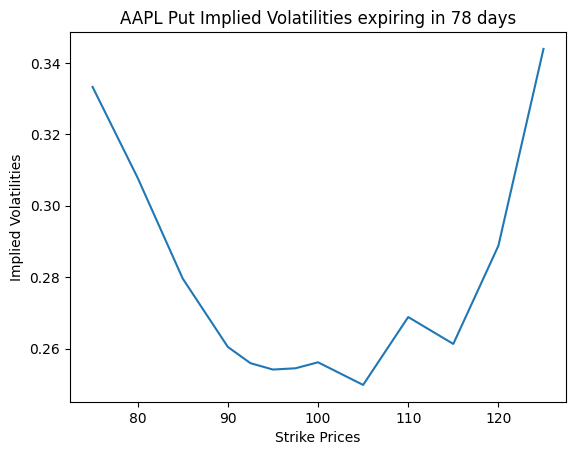

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(strikes, impvols_put)
plt.xlabel('Strike Prices')
plt.ylabel('Implied Volatilities')
plt.title('AAPL Put Implied Volatilities expiring in 78 days')
plt.show()